In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import keras

dataset_path = os.listdir('/kaggle/input/shop-dataset/Shop DataSet')

label_types = os.listdir('/kaggle/input/shop-dataset/Shop DataSet')
print (label_types)  

['non shop lifters', 'shop lifters']


In [2]:
rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('/kaggle/input/shop-dataset/Shop DataSet' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('/kaggle/input/shop-dataset/Shop DataSet' + '/' +item) + '/' + room))
    
# Build a dataframe        
dataSet_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(dataSet_df.head())
print(dataSet_df.tail())

                tag                                         video_name
0  non shop lifters  /kaggle/input/shop-dataset/Shop DataSet/non sh...
1  non shop lifters  /kaggle/input/shop-dataset/Shop DataSet/non sh...
2  non shop lifters  /kaggle/input/shop-dataset/Shop DataSet/non sh...
3  non shop lifters  /kaggle/input/shop-dataset/Shop DataSet/non sh...
4  non shop lifters  /kaggle/input/shop-dataset/Shop DataSet/non sh...
              tag                                         video_name
850  shop lifters  /kaggle/input/shop-dataset/Shop DataSet/shop l...
851  shop lifters  /kaggle/input/shop-dataset/Shop DataSet/shop l...
852  shop lifters  /kaggle/input/shop-dataset/Shop DataSet/shop l...
853  shop lifters  /kaggle/input/shop-dataset/Shop DataSet/shop l...
854  shop lifters  /kaggle/input/shop-dataset/Shop DataSet/shop l...


In [3]:
df = dataSet_df.loc[:,['video_name','tag']]
df
df.to_csv('dataSet.csv')

In [4]:

from tensorflow import keras


import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Num GPUs Available:  0


In [6]:
dataSet_df = pd.read_csv("dataSet.csv")


print(f"Total videos in dataSet: {len(dataSet_df)}")



dataSet_df.sample(10)

Total videos in dataSet: 855


,Unnamed: 0,video_name,tag
822,822,/kaggle/input/shop-dataset/Shop DataSet/shop l...,shop lifters
301,301,/kaggle/input/shop-dataset/Shop DataSet/non sh...,non shop lifters
852,852,/kaggle/input/shop-dataset/Shop DataSet/shop l...,shop lifters
277,277,/kaggle/input/shop-dataset/Shop DataSet/non sh...,non shop lifters
569,569,/kaggle/input/shop-dataset/Shop DataSet/shop l...,shop lifters
714,714,/kaggle/input/shop-dataset/Shop DataSet/shop l...,shop lifters
451,451,/kaggle/input/shop-dataset/Shop DataSet/non sh...,non shop lifters
679,679,/kaggle/input/shop-dataset/Shop DataSet/shop l...,shop lifters
811,811,/kaggle/input/shop-dataset/Shop DataSet/shop l...,shop lifters
566,566,/kaggle/input/shop-dataset/Shop DataSet/shop l...,shop lifters


In [7]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
IMG_SIZE = 224


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [8]:
import keras
# Load video frames with batching
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]  # Convert BGR to RGB
            frames.append(frame)

            if max_frames > 0 and len(frames) == max_frames:
                break
    finally:
        cap.release()
    
    return np.array(frames)

# Build feature extractor using InceptionV3
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="/kaggle/input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    
    return keras.Model(inputs, outputs, name="feature_extractor")

# Create the feature extractor
feature_extractor = build_feature_extractor()

# Function to extract features in batches
def extract_features_from_video(video_path, batch_size=32, max_frames=0):
    frames = load_video(video_path, max_frames=max_frames)
    features = []
    
    # Process frames in batches
    for i in range(0, len(frames), batch_size):
        batch = frames[i:i + batch_size]
        batch_features = feature_extractor.predict(batch)
        features.append(batch_features)

    return np.concatenate(features, axis=0)

In [9]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(dataSet_df["tag"]))
print(label_processor.get_vocabulary())

labels = dataSet_df["tag"].values
# Assuming 'tag' is the correct column name
labels = label_processor(dataSet_df["tag"].values).numpy()

labels

['non shop lifters', 'shop lifters']


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
#Define hyperparameters

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [11]:
def prepare_all_videos(df, root_dir, batch_size=32):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()

    # Take all class labels from train_df column named 'tag' and store in labels
    labels = df["tag"].values

    # Convert class labels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")  # (num_samples, MAX_SEQ_LENGTH)
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")  # (num_samples, MAX_SEQ_LENGTH, NUM_FEATURES)

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames
        frames = load_video(os.path.join(root_dir, path))
        print(len(frames))
        video_length = frames.shape[0]

        # Initialize a mask for the current video
        length = min(MAX_SEQ_LENGTH, video_length)
        frame_masks[idx, :length] = 1  # Mark the valid frames in the mask

        # Extract features in batches
        for start in range(0, video_length, batch_size):
            end = min(start + batch_size, video_length)
            batch = frames[start:end]

            # Make predictions for the current batch
            batch_features = feature_extractor.predict(batch)

            # Assign features to the corresponding positions
            for j in range(len(batch_features)):
                if start + j < MAX_SEQ_LENGTH:
                    frame_features[idx, start + j, :] = batch_features[j]

    return (frame_features, frame_masks), labels

# Example usage
train_data, train_labels = prepare_all_videos(dataSet_df, "train")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
print(f"Train labels in train set: {train_labels.shape}")

350
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
275
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
425
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━


KeyboardInterrupt



In [12]:
import pickle

with open('labels.pkl', 'wb') as file:
    pickle.dump(train_labels, file)

NameError: name 'train_labels' is not defined

In [16]:
import pickle
# Load from a file
with open('/kaggle/input/train-data/data.pkl', 'rb') as file:
    data = pickle.load(file)

print(len(data[0]))


855


In [13]:
with open('/kaggle/input/train-labels/labels.pkl', 'rb') as file:
    labels = pickle.load(file)

print(len(labels))

855


In [17]:
from sklearn.model_selection import train_test_split

# Extract frame features, frame masks, and labels
frame_features, frame_masks = data  # train_data[0] and train_data[1]
labels = labels

# Split the data into training and test sets
(
    X_train_features, X_test_features, 
    X_train_masks, X_test_masks, 
    y_train, y_test
) = train_test_split(frame_features, frame_masks, labels, test_size=0.2, random_state=42)

# Now you have split the data:
print(f"Training frame features shape: {X_train_features.shape}")
print(f"Test frame features shape: {X_test_features.shape}")
print(f"Training frame masks shape: {X_train_masks.shape}")
print(f"Test frame masks shape: {X_test_masks.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")


Training frame features shape: (684, 20, 2048)
Test frame features shape: (171, 20, 2048)
Training frame masks shape: (684, 20)
Test frame masks shape: (171, 20)
Training labels shape: (684, 1)
Test labels shape: (171, 1)


In [32]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

def run_experiment():
    filepath = "/tmp/video_classifier.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [X_train_features, X_train_masks],
        y_train,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([X_test_features, X_test_masks], y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model
_, sequence_model = run_experiment()


Epoch 1/100
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5251 - loss: 0.7336
Epoch 1: val_loss improved from inf to 0.61626, saving model to /tmp/video_classifier.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5311 - loss: 0.7273 - val_accuracy: 0.6788 - val_loss: 0.6163
Epoch 2/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6409 - loss: 0.6408
Epoch 2: val_loss improved from 0.61626 to 0.58348, saving model to /tmp/video_classifier.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6379 - loss: 0.6418 - val_accuracy: 0.6788 - val_loss: 0.5835
Epoch 3/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6961 - loss: 0.6073
Epoch 3: val_loss improved from 0.58348 to 0.52183, saving model to /tmp/video_classifier.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6967 - loss: 0.6069 - val_accuracy: 0.8029 - val_loss: 0.5218
Epoch 4/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7773 - loss: 0.5596
Epoch 4: 

In [33]:
def extract_video_features(video_path, batch_size=32):
    # Load the video and get its frames
    frames = load_video(video_path)
    video_length = frames.shape[0]

    # Initialize frame masks and features for this single video
    frame_masks = np.zeros(shape=(1, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Initialize a mask for the current video (mark the valid frames in the mask)
    length = min(MAX_SEQ_LENGTH, video_length)
    frame_masks[0, :length] = 1

    # Extract features in batches
    for start in range(0, video_length, batch_size):
        end = min(start + batch_size, video_length)
        batch = frames[start:end]

        # Extract features for the current batch using the feature extractor
        batch_features = feature_extractor.predict(batch)

        # Assign the features to the corresponding positions
        for j in range(len(batch_features)):
            if start + j < MAX_SEQ_LENGTH:
                frame_features[0, start + j, :] = batch_features[j]

    return frame_features, frame_masks

# Function to predict the class for a new video
def predict_video_class(video_path):
    # Extract features and masks for the video
    video_features, video_masks = extract_video_features(video_path)

    # Use the trained sequence model to predict the class
    class_probs = sequence_model.predict([video_features, video_masks])
    predicted_class_idx = np.argmax(class_probs, axis=1)[0]

    # Convert the predicted index back to the class name
    predicted_class_name = label_processor.get_vocabulary()[predicted_class_idx]

    return predicted_class_name

# Example usage
video_path = "/kaggle/input/shop-dataset/Shop DataSet/non shop lifters/shop_lifter_n_105.mp4"
predicted_class = predict_video_class(video_path)
print(f"Predicted class for the video: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Predicted class for the video: non shop lifters


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step 


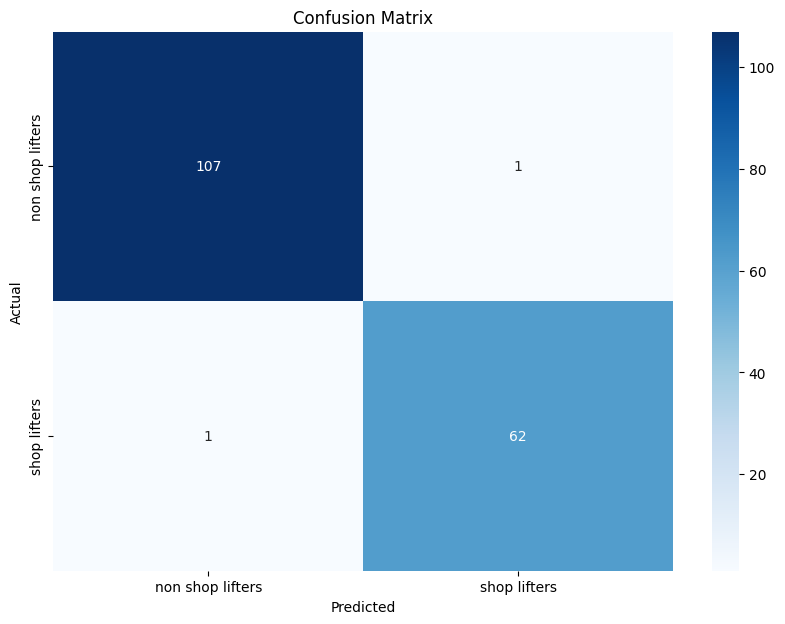

Classification Report:

                  precision    recall  f1-score   support

non shop lifters       0.99      0.99      0.99       108
    shop lifters       0.98      0.98      0.98        63

        accuracy                           0.99       171
       macro avg       0.99      0.99      0.99       171
    weighted avg       0.99      0.99      0.99       171



In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate the model and print the confusion matrix and classification report
def evaluate_model(seq_model, X_test_features, X_test_masks, y_test):
    # Make predictions on the test set
    y_pred_prob = seq_model.predict([X_test_features, X_test_masks])
    
    # Convert predicted probabilities to class labels
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_processor.get_vocabulary(), yticklabels=label_processor.get_vocabulary())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print("Classification Report:\n")
    report = classification_report(y_test, y_pred, target_names=label_processor.get_vocabulary())
    print(report)

# Example usage
evaluate_model(sequence_model, X_test_features, X_test_masks, y_test)
